In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#Set Parameters
im_width = 256
im_height = 256

In [3]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_21.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_3.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_15.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_1.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_17.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_6.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_9.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_11.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_19.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/

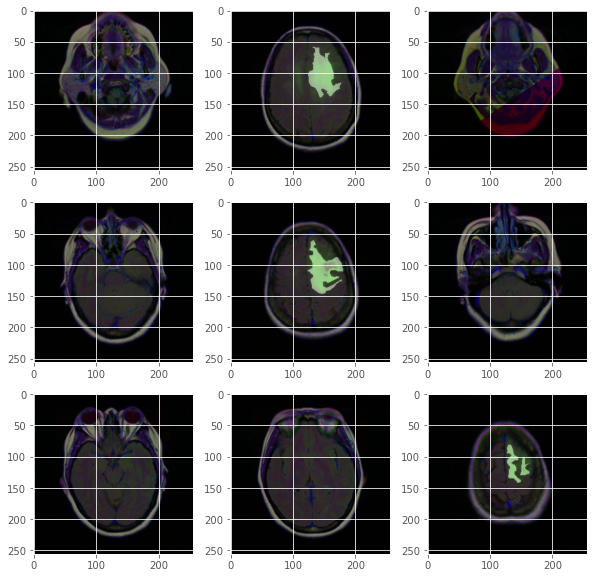

In [4]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [5]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [6]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)


In [7]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [8]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [9]:
model = unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
_______________________________________________________________________________________

In [10]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [11]:
train_generator_args = dict(rotation_range=0.2,width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/150
89/88 [==============================] - ETA: 0s - loss: -0.1127 - binary_accuracy: 0.9186 - iou: 0.0609 - dice_coef: 0.1130Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.02632, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 159s 2s/step - loss: -0.1127 - binary_accuracy: 0.9186 - iou: 0.0609 - dice_coef: 0.1130 - val_loss: -0.0263 - val_binary_accuracy: 0.9606 - val_iou: 0.0140 - val_dice_coef: 0.0275
Epoch 2/150
89/88 [==============================] - ETA: 0s - loss: -0.1778 - binary_accuracy: 0.9832 - iou: 0.0981 - dice_coef: 0.1769
Epoch 00002: val_loss improved from -0.02632 to -0.03447, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 102s 1s/step - loss: -0.1778 - binary_accuracy: 0.9832 - iou: 0.0981 - dice_coef: 0.1769 - val_loss: -0.0345 - val_binary_

89/88 [==============================] - ETA: 0s - loss: -0.7933 - binary_accuracy: 0.9969 - iou: 0.6636 - dice_coef: 0.7937
Epoch 00019: val_loss improved from -0.76891 to -0.78113, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 96s 1s/step - loss: -0.7933 - binary_accuracy: 0.9969 - iou: 0.6636 - dice_coef: 0.7937 - val_loss: -0.7811 - val_binary_accuracy: 0.9972 - val_iou: 0.6323 - val_dice_coef: 0.7593
Epoch 20/150
89/88 [==============================] - ETA: 0s - loss: -0.8013 - binary_accuracy: 0.9970 - iou: 0.6758 - dice_coef: 0.8018
Epoch 00020: val_loss did not improve from -0.78113
89/88 [==============================] - 96s 1s/step - loss: -0.8013 - binary_accuracy: 0.9970 - iou: 0.6758 - dice_coef: 0.8018 - val_loss: -0.7367 - val_binary_accuracy: 0.9965 - val_iou: 0.5977 - val_dice_coef: 0.7403
Epoch 21/150
89/88 [==============================] - ETA: 0s - loss: -0.8113 - binary_accuracy: 0.9971 - iou: 0.6874 - dice_coef: 0.8112
Epoch 0

89/88 [==============================] - ETA: 0s - loss: -0.8722 - binary_accuracy: 0.9977 - iou: 0.7787 - dice_coef: 0.8727
Epoch 00038: val_loss improved from -0.85780 to -0.86140, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 93s 1s/step - loss: -0.8722 - binary_accuracy: 0.9977 - iou: 0.7787 - dice_coef: 0.8727 - val_loss: -0.8614 - val_binary_accuracy: 0.9976 - val_iou: 0.7610 - val_dice_coef: 0.8626
Epoch 39/150
89/88 [==============================] - ETA: 0s - loss: -0.8676 - binary_accuracy: 0.9976 - iou: 0.7723 - dice_coef: 0.8672
Epoch 00039: val_loss did not improve from -0.86140
89/88 [==============================] - 92s 1s/step - loss: -0.8676 - binary_accuracy: 0.9976 - iou: 0.7723 - dice_coef: 0.8672 - val_loss: -0.8279 - val_binary_accuracy: 0.9966 - val_iou: 0.7144 - val_dice_coef: 0.8300
Epoch 40/150
89/88 [==============================] - ETA: 0s - loss: -0.8557 - binary_accuracy: 0.9974 - iou: 0.7537 - dice_coef: 0.8561
Epoch 0

Epoch 58/150
89/88 [==============================] - ETA: 0s - loss: -0.8964 - binary_accuracy: 0.9980 - iou: 0.8160 - dice_coef: 0.8965
Epoch 00058: val_loss did not improve from -0.86610
89/88 [==============================] - 90s 1s/step - loss: -0.8964 - binary_accuracy: 0.9980 - iou: 0.8160 - dice_coef: 0.8965 - val_loss: -0.8631 - val_binary_accuracy: 0.9974 - val_iou: 0.7671 - val_dice_coef: 0.8657
Epoch 59/150
89/88 [==============================] - ETA: 0s - loss: -0.8825 - binary_accuracy: 0.9978 - iou: 0.7939 - dice_coef: 0.8825
Epoch 00059: val_loss did not improve from -0.86610
89/88 [==============================] - 89s 1s/step - loss: -0.8825 - binary_accuracy: 0.9978 - iou: 0.7939 - dice_coef: 0.8825 - val_loss: -0.8512 - val_binary_accuracy: 0.9973 - val_iou: 0.7457 - val_dice_coef: 0.8512
Epoch 60/150
89/88 [==============================] - ETA: 0s - loss: -0.8809 - binary_accuracy: 0.9977 - iou: 0.7913 - dice_coef: 0.8811
Epoch 00060: val_loss did not improve fr

89/88 [==============================] - ETA: 0s - loss: -0.8838 - binary_accuracy: 0.9977 - iou: 0.7955 - dice_coef: 0.8838
Epoch 00077: val_loss did not improve from -0.89728
89/88 [==============================] - 91s 1s/step - loss: -0.8838 - binary_accuracy: 0.9977 - iou: 0.7955 - dice_coef: 0.8838 - val_loss: -0.8864 - val_binary_accuracy: 0.9978 - val_iou: 0.8019 - val_dice_coef: 0.8885
Epoch 78/150
89/88 [==============================] - ETA: 0s - loss: -0.9022 - binary_accuracy: 0.9980 - iou: 0.8288 - dice_coef: 0.9027
Epoch 00078: val_loss did not improve from -0.89728
89/88 [==============================] - 92s 1s/step - loss: -0.9022 - binary_accuracy: 0.9980 - iou: 0.8288 - dice_coef: 0.9027 - val_loss: -0.8860 - val_binary_accuracy: 0.9979 - val_iou: 0.7764 - val_dice_coef: 0.8625
Epoch 79/150
89/88 [==============================] - ETA: 0s - loss: -0.9074 - binary_accuracy: 0.9981 - iou: 0.8354 - dice_coef: 0.9077
Epoch 00079: val_loss did not improve from -0.89728
8

Epoch 97/150
89/88 [==============================] - ETA: 0s - loss: -0.9152 - binary_accuracy: 0.9983 - iou: 0.8472 - dice_coef: 0.9154
Epoch 00097: val_loss did not improve from -0.90246
89/88 [==============================] - 101s 1s/step - loss: -0.9152 - binary_accuracy: 0.9983 - iou: 0.8472 - dice_coef: 0.9154 - val_loss: -0.8883 - val_binary_accuracy: 0.9981 - val_iou: 0.7964 - val_dice_coef: 0.8837
Epoch 98/150
89/88 [==============================] - ETA: 0s - loss: -0.9159 - binary_accuracy: 0.9983 - iou: 0.8475 - dice_coef: 0.9161
Epoch 00098: val_loss improved from -0.90246 to -0.90456, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 101s 1s/step - loss: -0.9159 - binary_accuracy: 0.9983 - iou: 0.8475 - dice_coef: 0.9161 - val_loss: -0.9046 - val_binary_accuracy: 0.9980 - val_iou: 0.8335 - val_dice_coef: 0.9073
Epoch 99/150
89/88 [==============================] - ETA: 0s - loss: -0.9157 - binary_accuracy: 0.9983 - iou: 0.8469 - dice_coef:

Epoch 117/150
89/88 [==============================] - ETA: 0s - loss: -0.7943 - binary_accuracy: 0.9925 - iou: 0.6915 - dice_coef: 0.7948
Epoch 00117: val_loss did not improve from -0.90635
89/88 [==============================] - 97s 1s/step - loss: -0.7943 - binary_accuracy: 0.9925 - iou: 0.6915 - dice_coef: 0.7948 - val_loss: -0.8526 - val_binary_accuracy: 0.9971 - val_iou: 0.7491 - val_dice_coef: 0.8542
Epoch 118/150
89/88 [==============================] - ETA: 0s - loss: -0.2364 - binary_accuracy: 0.9843 - iou: 0.1572 - dice_coef: 0.2347
Epoch 00118: val_loss did not improve from -0.90635
89/88 [==============================] - 98s 1s/step - loss: -0.2364 - binary_accuracy: 0.9843 - iou: 0.1572 - dice_coef: 0.2347 - val_loss: -0.8445 - val_binary_accuracy: 0.9969 - val_iou: 0.7364 - val_dice_coef: 0.8454
Epoch 119/150
89/88 [==============================] - ETA: 0s - loss: -0.8982 - binary_accuracy: 0.9980 - iou: 0.8192 - dice_coef: 0.8983
Epoch 00119: val_loss did not improve

Epoch 137/150
89/88 [==============================] - ETA: 0s - loss: -0.9211 - binary_accuracy: 0.9984 - iou: 0.8591 - dice_coef: 0.9208
Epoch 00137: val_loss did not improve from -0.91013
89/88 [==============================] - 101s 1s/step - loss: -0.9211 - binary_accuracy: 0.9984 - iou: 0.8591 - dice_coef: 0.9208 - val_loss: -0.9043 - val_binary_accuracy: 0.9981 - val_iou: 0.8265 - val_dice_coef: 0.9040
Epoch 138/150
89/88 [==============================] - ETA: 0s - loss: -0.9243 - binary_accuracy: 0.9985 - iou: 0.8633 - dice_coef: 0.9242
Epoch 00138: val_loss did not improve from -0.91013
89/88 [==============================] - 101s 1s/step - loss: -0.9243 - binary_accuracy: 0.9985 - iou: 0.8633 - dice_coef: 0.9242 - val_loss: -0.9020 - val_binary_accuracy: 0.9981 - val_iou: 0.8233 - val_dice_coef: 0.9021
Epoch 139/150
89/88 [==============================] - ETA: 0s - loss: -0.9290 - binary_accuracy: 0.9986 - iou: 0.8686 - dice_coef: 0.9290
Epoch 00139: val_loss did not impro

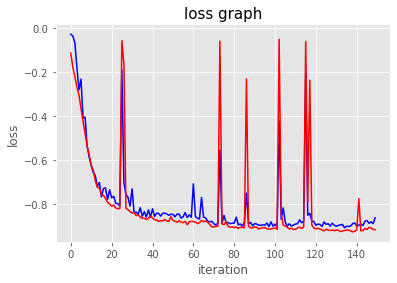

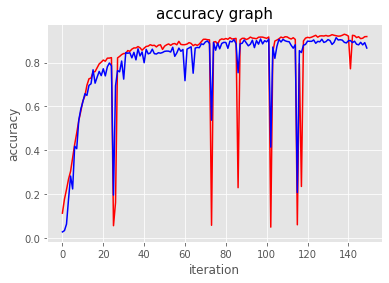

In [12]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [13]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [14]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
13/12 [===============================] - 6s 437ms/step - loss: -0.9136 - binary_accuracy: 0.9985 - iou: 0.8426 - dice_coef: 0.9131
Test lost:  -0.9135669469833374
Test IOU:  0.9985020756721497
Test Dice Coefficent:  0.8425788283348083


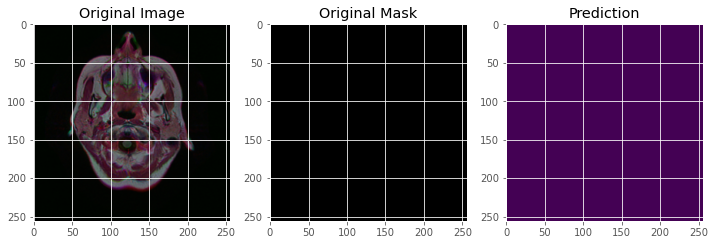

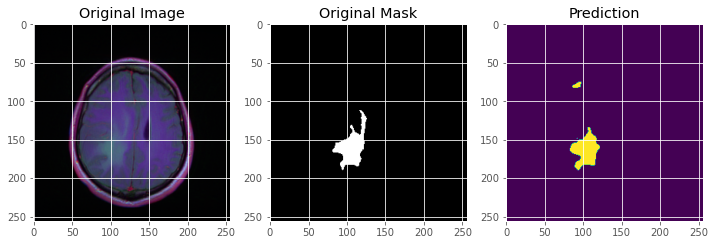

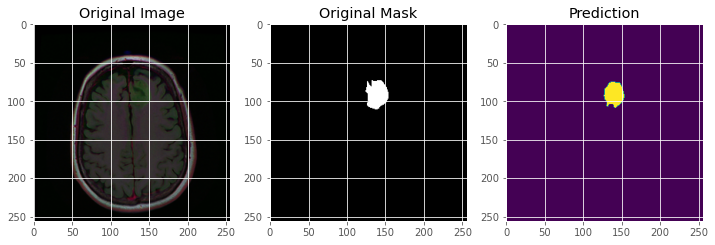

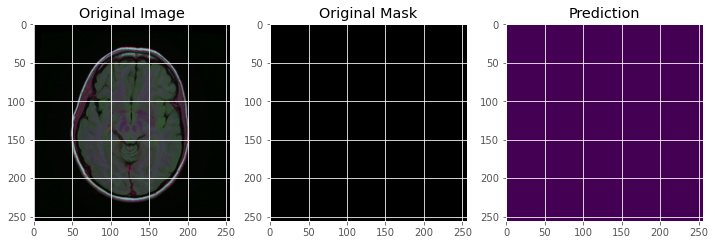

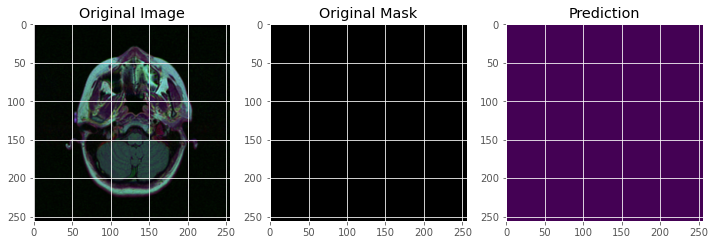

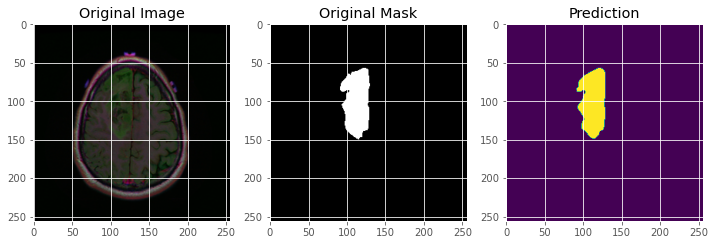

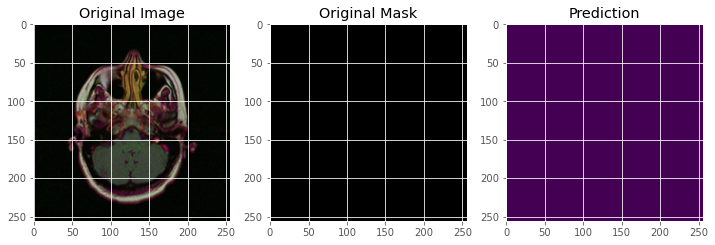

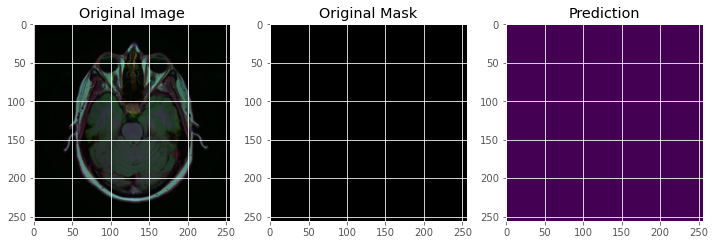

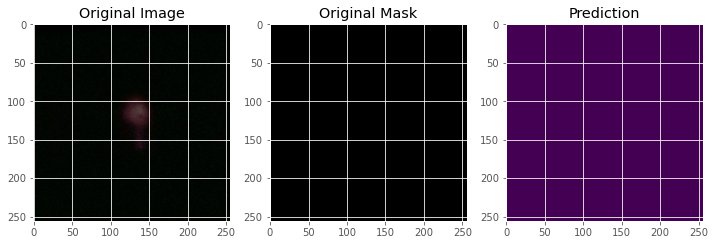

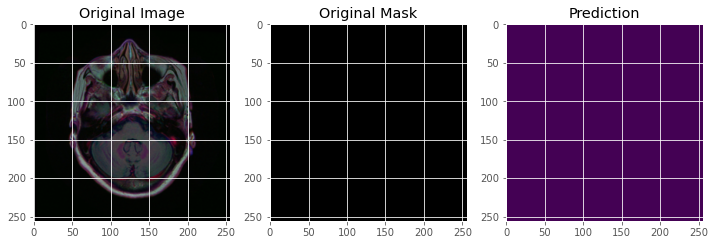

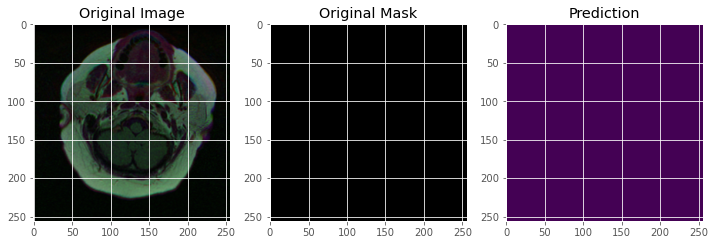

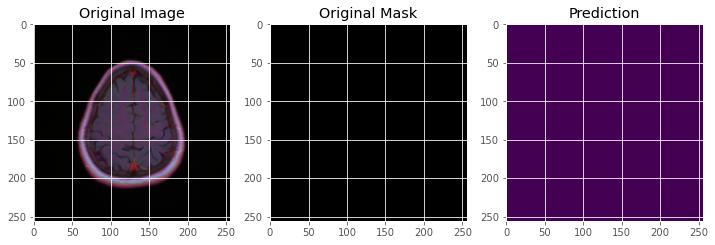

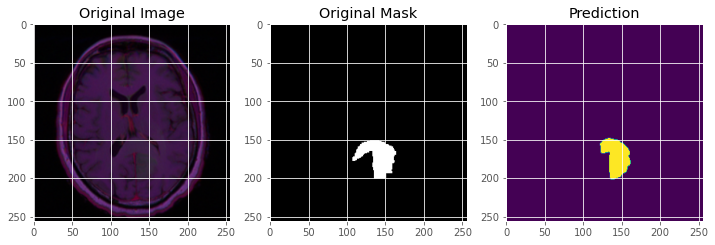

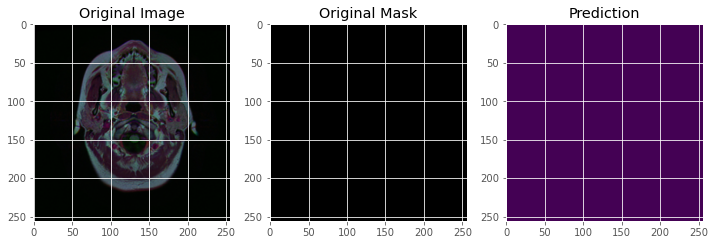

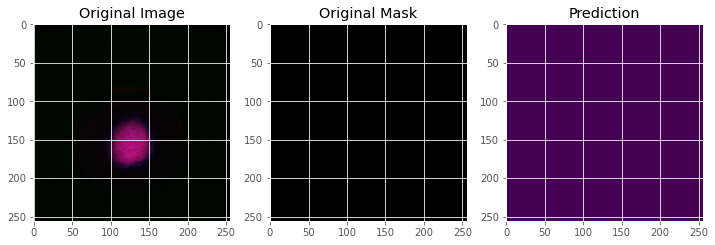

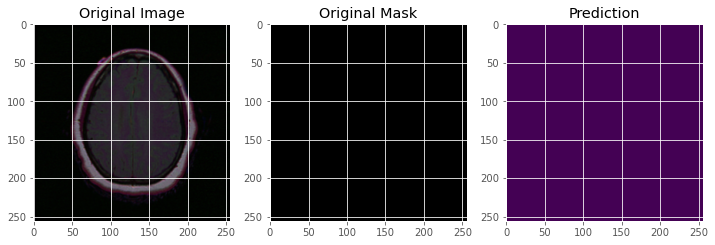

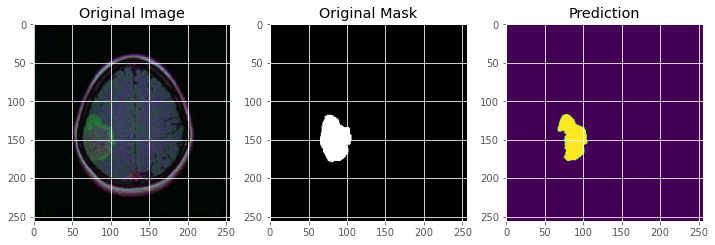

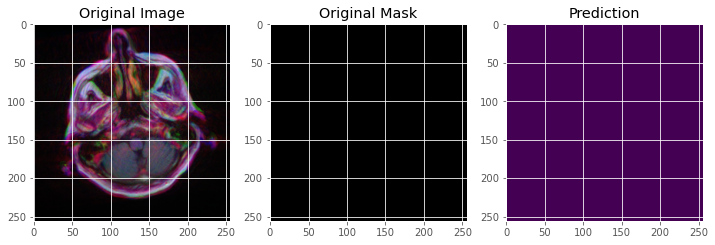

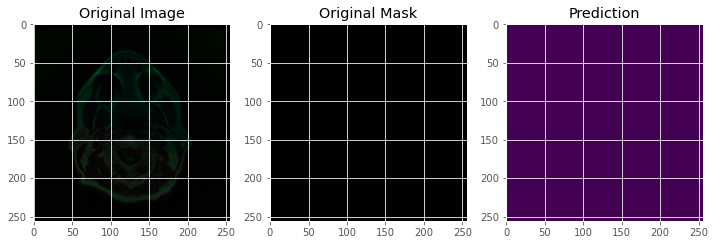

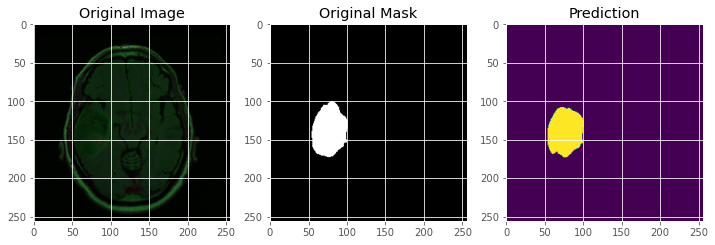

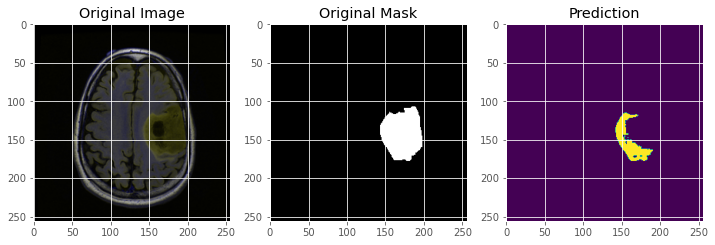

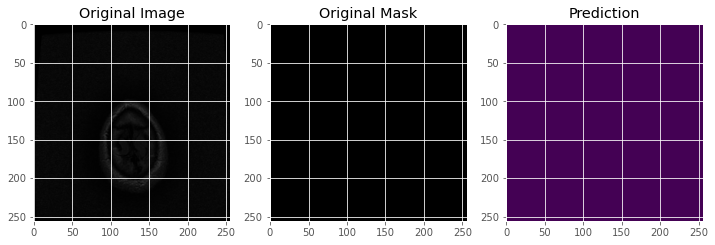

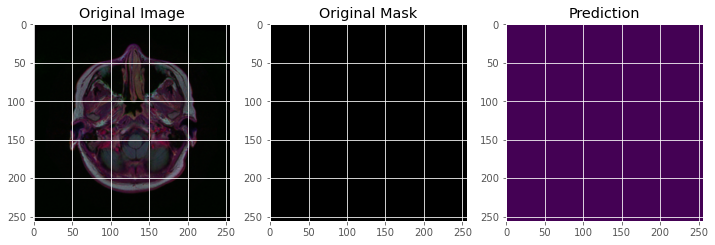

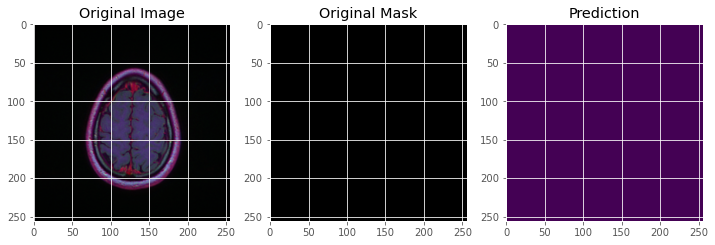

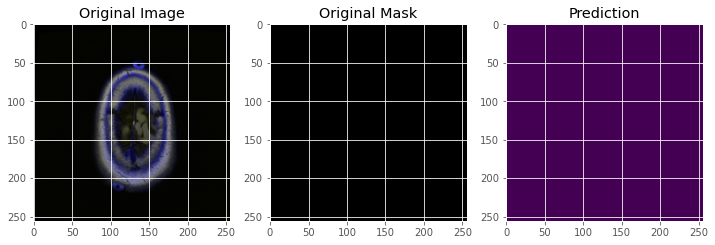

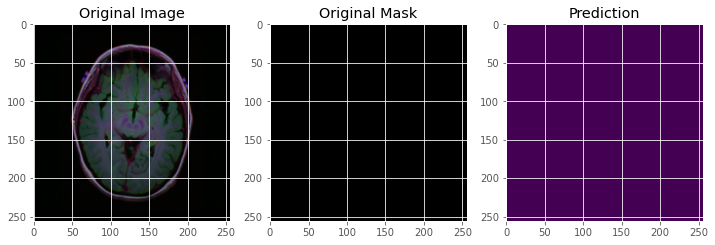

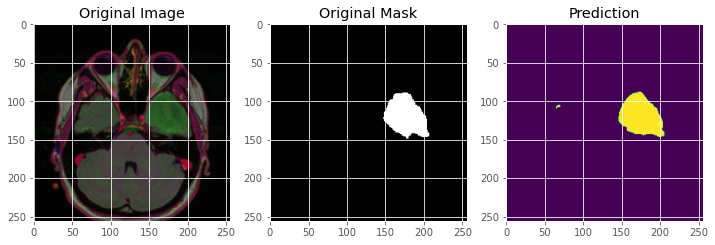

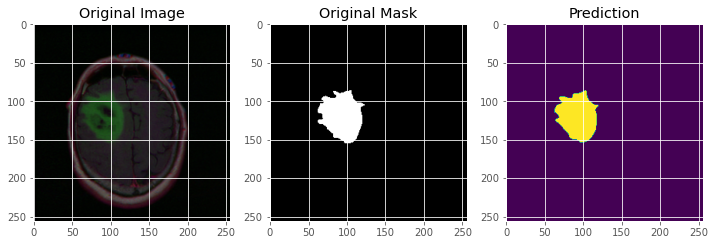

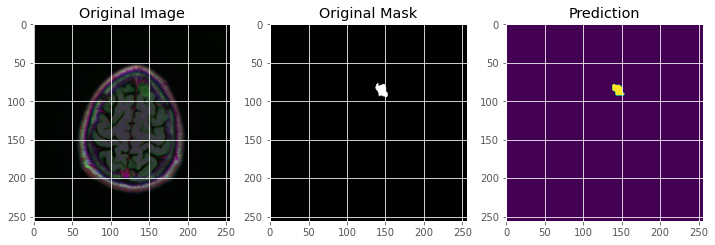

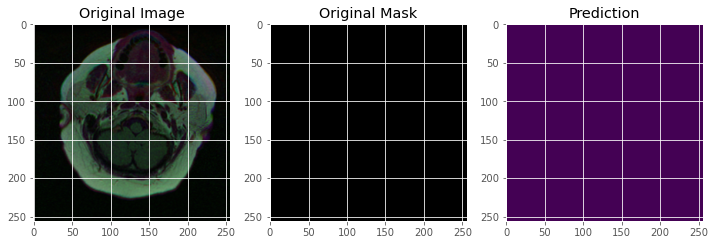

In [16]:

for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [ ]:
from IPython.display import FileLink
FileLink('./unet_brain_mri_seg.hdf5')